In [26]:
import requests
import json
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Successfully authenticated!
Request URL: https://catalogue.dataspace.copernicus.eu/odata/v1/Products?%24filter=OData.CSC.Intersects%28area%3Dgeography%27SRID%3D4326%3BPOLYGON%28%28-122.2081+37.7394%2C+-122.2081+37.7494%2C+-122.1981+37.7494%2C+-122.1981+37.7394%2C+-122.2081+37.7394%29%29%27%29+++++++++++++and+ContentDate%2FStart+gt+2023-01-01T00%3A00%3A00.000Z+++++++++++++and+ContentDate%2FStart+lt+2024-03-01T00%3A00%3A00.000Z+++++++++++++and+Collection%2FName+eq+%27SENTINEL-1%27+++++++++++++and+contains%28Name%2C+%27IW_ETA%27%29&%24orderby=ContentDate%2FStart&%24top=100


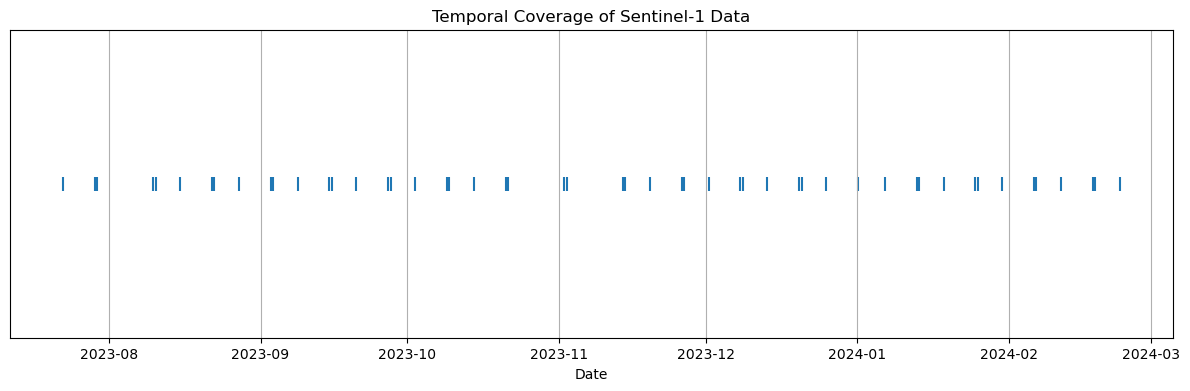


Total products found: 51

Date range:
First: 2023-07-22 14:16:32.580645+00:00
Last: 2024-02-23 14:16:31.378299+00:00

Average file size: 75.5 MB
Total data volume: 3.8 GB


In [53]:
username =
password =

# Authentication endpoints
AUTH_URL = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
API_URL = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products"

def get_access_token(username, password):
    data = {
        'grant_type': 'password',
        'username': username,
        'password': password,
        'client_id': 'cdse-public'
    }
    
    response = requests.post(AUTH_URL, data=data)
    if response.status_code == 200:
        return response.json()['access_token']
    else:
        raise Exception(f"Authentication failed: {response.text}")

def search_products(access_token, params):
    headers = {
        'Authorization': f'Bearer {access_token}',
        'Accept': 'application/json'
    }
    
    response = requests.get(API_URL, headers=headers, params=params)
    print(f"Request URL: {response.url}")
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Search failed: {response.text}")

try:
    token = get_access_token(username, password)
    print("Successfully authenticated!")
    
    search_params = {
        '$filter': """
            OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((-122.2081 37.7394, -122.2081 37.7494, -122.1981 37.7494, -122.1981 37.7394, -122.2081 37.7394))')
            and ContentDate/Start gt 2023-01-01T00:00:00.000Z
            and ContentDate/Start lt 2024-03-01T00:00:00.000Z
            and Collection/Name eq 'SENTINEL-1'
            and contains(Name, 'IW_ETA')
        """.strip().replace('\n', ' '),
        '$orderby': 'ContentDate/Start',
        '$top': 100
    }
    
    results = search_products(token, search_params)
    
    if results.get('value'):
        df = pd.DataFrame(results['value'])
        df['StartDate'] = pd.to_datetime(df['ContentDate'].apply(lambda x: x['Start']))
        df['EndDate'] = pd.to_datetime(df['ContentDate'].apply(lambda x: x['End']))
        df['ContentSize_MB'] = df['ContentLength'] / (1024 * 1024)
        
        # Visualize temporal coverage
        plt.figure(figsize=(15, 4))
        plt.scatter(df['StartDate'], [1] * len(df), marker='|', s=100)
        plt.title('Temporal Coverage of Sentinel-1 Data')
        plt.xlabel('Date')
        plt.yticks([])
        plt.grid(True, axis='x')
        plt.show()
        
        print(f"\nTotal products found: {len(df)}")
        print("\nDate range:")
        print(f"First: {df['StartDate'].min()}")
        print(f"Last: {df['StartDate'].max()}")
        print(f"\nAverage file size: {df['ContentSize_MB'].mean():.1f} MB")
        print(f"Total data volume: {df['ContentSize_MB'].sum()/1024:.1f} GB")
        
        df.to_csv('../data/sentinel_metadata.csv', index=False)
        
    else:
        print("No products found")

except Exception as e:
    print(f"Error: {e}")




In [48]:
import zipfile

In [50]:
filename = os.path.join('../data/raw/sentinel', f"{df.iloc[2]['Name']}.zip")

# Check the zip contents
print(f"Examining zip file: {filename}")
print("\nContents:")
with zipfile.ZipFile(filename, 'r') as zip_ref:
    for file in zip_ref.namelist():
        info = zip_ref.getinfo(file)
        size_mb = info.file_size / (1024 * 1024)
        print(f"{file}: {size_mb:.1f} MB")

Examining zip file: ../data/raw/sentinel/S1A_IW_ETA__AXDV_20231208T140810_20231208T140837_051564_063997_1854.SAFE.zip

Contents:
S1A_IW_ETA__AXDV_20231208T140810_20231208T140837_051564_063997_1854.SAFE/annotation/S1A_IW_ETA__AXDV_20231208T140810_20231208T140837_051564_063997.xml: 0.3 MB
S1A_IW_ETA__AXDV_20231208T140810_20231208T140837_051564_063997_1854.SAFE/annotation/S1A_OPER_AUX_POEORB_ETAD_20231229T045625_V20231208T140622_20231208T141022.EOF: 0.0 MB
S1A_IW_ETA__AXDV_20231208T140810_20231208T140837_051564_063997_1854.SAFE/manifest.safe: 0.0 MB
S1A_IW_ETA__AXDV_20231208T140810_20231208T140837_051564_063997_1854.SAFE/measurement/S1A_IW_ETA__AXDV_20231208T140810_20231208T140837_051564_063997.nc: 76.7 MB
S1A_IW_ETA__AXDV_20231208T140810_20231208T140837_051564_063997_1854.SAFE/preview/s1a-iw-eta-dv-20231208t140810-20231208t140837-051564-063997-000.kmz: 0.8 MB
S1A_IW_ETA__AXDV_20231208T140810_20231208T140837_051564_063997_1854.SAFE/support/aux_poeorb.xsd: 0.0 MB
S1A_IW_ETA__AXDV_20231208T

In [ ]:
def download_sentinel_image(product_id, product_name, token, base_dir='../data/raw/sentinel'):
    """Download a single Sentinel image"""
    download_url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
    
    headers = {
        'Authorization': f'Bearer {token}',
        'Accept': '*/*'
    }
    
    filename = os.path.join(base_dir, f"{product_name}.zip")
    
    # Skip if file already exists
    if os.path.exists(filename):
        print(f"File already exists: {filename}")
        return True
    
    response = requests.get(download_url, headers=headers, stream=True)
    
    if response.status_code == 200:
        total_size = int(response.headers.get('content-length', 0))
        
        with open(filename, 'wb') as f:
            if total_size == 0:
                f.write(response.content)
            else:
                downloaded = 0
                total_size_mb = total_size / (1024 * 1024)
                for data in response.iter_content(chunk_size=4096):
                    downloaded += len(data)
                    f.write(data)
                    done = int(50 * downloaded / total_size)
                    print(f"\rDownload Progress: [{'=' * done}{' ' * (50-done)}] {downloaded/(1024*1024):.1f}/{total_size_mb:.1f} MB", 
                          end='', flush=True)
        print(f"\nDownloaded: {filename}")
        return True
    else:
        print(f"Error downloading {product_name}: {response.status_code}")
        return False

try:
    token = get_access_token(username, password)
    print("Successfully authenticated!")
    
    total_images = len(df)
    successful_downloads = 0
    
    for idx, row in df.iterrows():
        print(f"\nDownloading image {idx + 1} of {total_images}")
        print(f"Date: {row['StartDate']}")
        
        if download_sentinel_image(row['Id'], row['Name'], token):
            successful_downloads += 1
        
        # Get fresh token every 5 downloads
        if (idx + 1) % 5 == 0:
            token = get_access_token(username, password)
            print("\nRefreshed authentication token")
    
    print(f"\nDownload complete! Successfully downloaded {successful_downloads} of {total_images} images")

except Exception as e:
    print(f"Error: {e}")

Successfully authenticated!

Date: 2023-07-22 14:16:32.580645+00:00
Download Progress: [========                                          ] 11.7/71.7 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [==============================                    ] 44.4/71.7 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [==================================================] 71.7/71.7 MB
Downloaded: ../data/raw/sentinel/S1A_IW_ETA__AXDV_20230722T141632_20230722T141659_049537_05F4E5_2D88.SAFE.zip

Date: 2023-07-29 02:07:52.463343+00:00
Download Progress: [=======                                           ] 11.7/76.7 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [===========================                       ] 41.9/76.7 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [===============================================   ] 72.9/76.7 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=======                                           ] 11.8/77.9 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [===========================                       ] 42.3/77.9 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [==============================================    ] 72.6/77.9 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=======                                           ] 12.0/76.1 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [===========================                       ] 42.4/76.1 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [================================================  ] 73.3/76.1 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=======                                           ] 11.7/78.1 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [==========================                        ] 41.0/78.1 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=======================================           ] 61.1/78.1 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [==================================================] 78.1/78.1 MB
Downloaded: ../data/raw/sentinel/S1A_IW_ETA__AXDV_20230810T140809_20230810T140836_049814_05FD9D_CD7D.SAFE.zip

Refreshed authentication token

Date: 2023-08-15 14:16:33.724340+00:00
Download Progress: [========                                          ] 11.7/72.5 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=============================                     ] 42.1/72.5 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [================================================= ] 71.6/72.5 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=======                                           ] 12.1/76.5 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [============================                      ] 44.2/76.5 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [================================================= ] 75.7/76.5 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=======                                           ] 12.3/77.4 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=======================                           ] 36.7/77.4 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [========================================          ] 62.3/77.4 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [========                                          ] 11.7/72.0 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [============================                      ] 40.7/72.0 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [================================================= ] 72.0/72.0 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [========                                          ] 13.2/76.5 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [====================================              ] 52.6/71.4 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=============================================     ] 68.6/76.0 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=======                                           ] 11.8/77.5 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [============================                      ] 43.6/77.5 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [================================================= ] 76.1/77.5 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [========                                          ] 11.8/72.2 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [==============================                    ] 43.6/72.2 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [==========================================        ] 63.9/76.1 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [======================                            ] 35.0/76.1 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [============================================      ] 68.0/76.1 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=======                                           ] 11.7/77.5 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [===============                                   ] 23.5/78.2 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=======================================           ] 60.6/76.2 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [=======                                           ] 11.7/78.4 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [============================                      ] 44.3/78.4 MB

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Download Progress: [===============================================   ] 73.7/78.4 MB

In [58]:
def verify_sentinel_downloads():
    metadata_df = pd.read_csv('../data/sentinel_metadata.csv')
    
    # Get list of downloaded files
    download_dir = '../data/raw/sentinel'
    downloaded_files = os.listdir(download_dir)
    
    print(f"Expected files: {len(metadata_df)}")
    print(f"Downloaded files: {len(downloaded_files)}")
    
    # Create verification dataframe
    verification = []
    
    for idx, row in metadata_df.iterrows():
        expected_filename = f"{row['Name']}.zip"
        file_path = os.path.join(download_dir, expected_filename)
        
        file_exists = os.path.exists(file_path)
        file_size_mb = os.path.getsize(file_path)/1024/1024 if file_exists else 0
        expected_size_mb = row['ContentSize_MB'] if 'ContentSize_MB' in row else None
        
        # Check if zip file is valid and contains .nc file
        zip_valid = False
        has_nc_file = False
        if file_exists:
            try:
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_valid = True
                    nc_files = [f for f in zip_ref.namelist() if f.endswith('.nc')]
                    has_nc_file = len(nc_files) > 0
            except zipfile.BadZipFile:
                zip_valid = False
        
        verification.append({
            'date': row['StartDate'],
            'filename': expected_filename,
            'downloaded': file_exists,
            'file_size_mb': round(file_size_mb, 1),
            'expected_size_mb': round(float(expected_size_mb), 1) if expected_size_mb else None,
            'size_match': abs(file_size_mb - expected_size_mb) < 1 if expected_size_mb else False,
            'valid_zip': zip_valid,
            'has_nc_file': has_nc_file
        })
    
    verify_df = pd.DataFrame(verification)
    
    # Summary statistics
    print("\nVerification Summary:")
    print(f"Total files expected: {len(metadata_df)}")
    print(f"Files downloaded: {verify_df['downloaded'].sum()}")
    print(f"Valid zip files: {verify_df['valid_zip'].sum()}")
    print(f"Files with NC data: {verify_df['has_nc_file'].sum()}")
    
    # Show any problems
    problems = verify_df[
        ~(verify_df['downloaded'] & 
          verify_df['valid_zip'] & 
          verify_df['has_nc_file'] & 
          verify_df['size_match'])
    ]
    
    if len(problems) > 0:
        print("\nProblem files:")
        display(problems)
    else:
        print("\nAll files verified successfully!")
    
    return verify_df

# Run verification
verify_df = verify_sentinel_downloads()

Expected files: 51
Downloaded files: 51

Verification Summary:
Total files expected: 51
Files downloaded: 51
Valid zip files: 51
Files with NC data: 51

All files verified successfully!


In [74]:
import netCDF4 as nc
import numpy as np
from zipfile import ZipFile
from osgeo import gdal
import xml.etree.ElementTree as ET
import xarray as xr

In [76]:
def process_sentinel_data(zip_path):
    """Process Sentinel-1 ETA data using xarray"""
    
    print(f"Processing: {zip_path}")
    
    with ZipFile(zip_path, 'r') as zip_ref:
        # Extract the NetCDF file
        nc_files = [f for f in zip_ref.namelist() if f.endswith('.nc')]
        if not nc_files:
            raise ValueError("No NetCDF file found in zip")
            
        print(f"\nNetCDF file: {nc_files[0]}")
        zip_ref.extract(nc_files[0], '../data/temp')
        nc_path = os.path.join('../data/temp', nc_files[0])
        
        try:
            # Open with xarray
            ds = xr.open_dataset(nc_path)
            
            # Print dataset information
            print("\nDataset Info:")
            print(ds.info())
            
            # Print coordinates and dimensions
            print("\nCoordinates and Dimensions:")
            print(ds.coords)
            
            # Print data variables
            print("\nData Variables:")
            print(ds.data_vars)
            
            # Try to access and plot some data
            for var_name in ds.data_vars:
                print(f"\nVariable: {var_name}")
                data = ds[var_name].values
                print(f"Shape: {data.shape}")
                print(f"Data type: {data.dtype}")
                print(f"Min: {np.nanmin(data)}")
                print(f"Max: {np.nanmax(data)}")
                
                # Plot first layer if data is 2D or 3D
                if len(data.shape) in [2, 3]:
                    plt.figure(figsize=(12, 8))
                    if len(data.shape) == 3:
                        plot_data = data[0]  # Take first layer
                    else:
                        plot_data = data
                    plt.imshow(plot_data, cmap='RdBu_r')
                    plt.colorbar(label=var_name)
                    plt.title(f'Variable: {var_name}')
                    plt.show()
            
            ds.close()
            
        except Exception as e:
            print(f"Error reading NetCDF file: {e}")
        
        finally:
            # Clean up
            os.remove(nc_path)

# Process our first file
sample_file = os.path.join('../data/raw/sentinel', verify_df.iloc[0]['filename'])
process_sentinel_data(sample_file)

Processing: ../data/raw/sentinel/S1A_IW_ETA__AXDV_20230722T141632_20230722T141659_049537_05F4E5_2D88.SAFE.zip

NetCDF file: S1A_IW_ETA__AXDV_20230722T141632_20230722T141659_049537_05F4E5_2D88.SAFE/measurement/S1A_IW_ETA__AXDV_20230722T141632_20230722T141659_049537_05F4E5.nc

Dataset Info:
xarray.Dataset {
dimensions:

variables:

// global attributes:
	:pIndex = 1 ;
	:azimuthTimeMin = 2023-07-22T14:16:32.580645 ;
	:azimuthTimeMax = 2023-07-22T14:16:59.648094 ;
	:rangeTimeMin = 0.005338442964314294 ;
	:rangeTimeMax = 0.006400439386461206 ;
}None

Coordinates and Dimensions:
Coordinates:
    *empty*

Data Variables:
Data variables:
    *empty*
